## Prepare packages

In [85]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


## Import simulation data

In [86]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all.shape

(610615, 12)

In [87]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


In [88]:
df_all = df_all.dropna()
df_all.shape

(610417, 12)

In [89]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       



## Normalize data

In [90]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

In [91]:
# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())


x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [92]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [93]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)


## Constraint 

In [94]:
length = y_s.shape[0]

# y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

# constraints!
e = 0.0001
y_depth_low = 0* np.random.uniform(0.1423-e, 0.1423+e, size=(length, 1))
y_depth_up = 0* np.random.uniform(0.4126-e, 0.4126+e, size=(length, 1))
y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

# print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_const shape: (610417, 2)


## Data distribution

In [95]:
# 기본 분할
cutoff_index = int(np.round(0.9 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
# y_ref_train, y_ref_val = y_s_ref[:cutoff_index], y_s_ref[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ------------------ Training set ------------------
n_train = cutoff_index - P - window
x_past_train = np.empty((n_train, window, 4))
y_past_train = np.empty((n_train, window, 2))
x_future_train = np.empty((n_train, P, 3))
y_ref_train_seq = np.empty((n_train, P, 1))
y_const_train_seq = np.empty((n_train, P, 2))

for i in tqdm(range(window, cutoff_index - P)):
    j = i - window
    x_past_train[j] = x_train[i-window:i]
    y_past_train[j] = y_train[i-window:i]
    x_future_train[j] = x_train[i:i+P, :3]         # 앞에서 3개
    y_ref_train_seq[j] = y_train[i:i+P, :1]  
    # y_ref_train_seq[j] = y_ref_train[i:i+P]
    y_const_train_seq[j] = y_const_train[i:i+P]

# ------------------ Validation set ------------------
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window
x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P)):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]
    y_ref_val_seq[j] = y_val[i:i+P, :1]  
    # y_ref_val_seq[j] = y_ref_val[i:i+P]
    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_train = torch.tensor(x_past_train, dtype=torch.float32)
y_past_train = torch.tensor(y_past_train, dtype=torch.float32)
x_future_train = torch.tensor(x_future_train, dtype=torch.float32)
y_ref_train_seq = torch.tensor(y_ref_train_seq, dtype=torch.float32)
y_const_train_seq = torch.tensor(y_const_train_seq, dtype=torch.float32)

print("x_past shape : ", x_past_train.shape)       # (n_train, 50, 4)
print("y_past shape : ",y_past_train.shape)       # (n_train, 50, 2)
print("x_future shape : ",x_future_train.shape)     # (n_train, 50, 3)
print("y_ref shape : ",y_ref_train_seq.shape)    # (n_train, 50, 1)
print("y_const shape : ",y_const_train_seq.shape)  # (n_train, 50, 2)

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

print("x_past_val shape : ", x_past_val.shape)       # (n_val, 50, 4)
print("y_past_val shape : ", y_past_val.shape)       # (n_val, 50, 2)
print("x_future_val shape : ", x_future_val.shape)   # (n_val, 50, 3)
print("y_ref_val shape : ", y_ref_val_seq.shape)     # (n_val, 50, 1)
print("y_const_val shape : ", y_const_val_seq.shape) # (n_val, 50, 2)




  0%|          | 0/549275 [00:00<?, ?it/s]

100%|██████████| 60942/60942 [00:00<00:00, 247151.50it/s]


x_past shape :  torch.Size([549275, 50, 4])
y_past shape :  torch.Size([549275, 50, 2])
x_future shape :  torch.Size([549275, 50, 3])
y_ref shape :  torch.Size([549275, 50, 1])
y_const shape :  torch.Size([549275, 50, 2])
x_past_val shape :  torch.Size([60942, 50, 4])
y_past_val shape :  torch.Size([60942, 50, 2])
x_future_val shape :  torch.Size([60942, 50, 3])
y_ref_val shape :  torch.Size([60942, 50, 1])
y_const_val shape :  torch.Size([60942, 50, 2])


## Trian / Validation data distribution

## Prediction model (Tide) import

In [96]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())


## Execution function define

In [97]:
import time

def plot_val_sample_policy_TiDE(k, model, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, u_shift, u_past_shift, c_shift, device, title="", model_name="", ax_list=None):
    model.eval()
    TiDE.eval()

    with torch.no_grad():
        start_time = time.time()
        x_past = val_x_past[k:k+1].to(device)

        #x_past[:,:,3] = x_past[:,:,3] + u_past_shift  # Shift the first feature (e.g., loc_Z)
        #x_past[:,-1,:3] = x_past[:,-1,:3] #**************

        y_past = val_y_past[k:k+1].to(device)

        y_past[:,:,1] = y_past[:,:,1] + c_shift  # Shift the depth signal
        
        x_future = val_x_future[k:k+1].to(device)
        y_ref = val_y_ref[k:k+1].to(device)
        y_const = val_y_const[k:k+1].to(device)

        policy_in_past = torch.cat((x_past, y_past), dim=2)
        policy_in_fut = torch.cat((x_future, y_ref, y_const), dim=2)
        u_pred = model((policy_in_past, policy_in_fut))  # [1, P, 1]
        #u_pred[:,:,:] = -u_pred[:,:,:]  # Shift the control signal
        
        u_pred = u_pred + u_shift  # Shift the control signal

        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        elapsed = time.time() - start_time  # 타이머 종료
        #print(f"Model {model_name} Sample #{k} inference time (no plot): {elapsed:.5f} sec")

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    u_pred = u_pred.squeeze(0).cpu().numpy()                      # [P, 1]
    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()     # [P, 2] (50% quantile)
    y_ref = y_ref.squeeze(0).cpu().numpy()                       # [P, 2]
    y_past = y_past.squeeze(0).cpu().numpy()                     # [window, 2]
    x_past_np = x_past[0].cpu().numpy()                          # [window, 4]

    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    control_past = x_past_np[:, 3]
    control_all = np.concatenate([control_past, u_pred.squeeze(-1)])

    # 2. Subplot 준비
    if ax_list is None:
        fig, ax_list = plt.subplots(3, 1, figsize=(8, 12))

    # Plot 1: Control
    ax_list[0].plot(np.arange(100), control_all[:], label="Control (past + predicted)")
    ax_list[0].axvline(49, color='gray', linestyle='--', linewidth=1)
    ax_list[0].set_ylabel("Control")
    ax_list[0].grid()
    ax_list[0].legend()

    # Plot 2: Temp
    ax_list[1].plot(time_past, y_past[:, 0], label="Temp (past)")
    ax_list[1].plot(time_future, y_ref[:, 0], '--', label="Temp (ref)")
    ax_list[1].plot(time_future, y_pred[:, 0], label="Temp (pred)")
    ax_list[1].set_ylabel("Temperature")
    ax_list[1].grid()
    ax_list[1].legend()

    # Plot 3: Depth
    ax_list[2].plot(time_past, y_past[:, 1], label="Depth (past)")
    # ax_list[2].plot(time_future, y_ref[:, 1], '--', label="Depth (ref)")  # optional
    ax_list[2].plot(time_future, y_pred[:, 1], label="Depth (pred)")
    ax_list[2].set_xlabel("Time")
    ax_list[2].set_ylabel("Depth")
    ax_list[2].grid()
    ax_list[2].legend()

    # 타이틀 (공통 super title은 외부 루프에서 관리할 수 있음)
    ax_list[0].set_title(f"{title} #{k}\n{model_name}")

    # Difference 계산 및 출력
    abs_diff = np.abs(y_pred - y_ref)  # [P, 2]
    mae = np.mean(abs_diff, axis=0)
    mse = np.mean((y_pred - y_ref) ** 2, axis=0)
    rmse = np.sqrt(mse)

    #print(f"Sample #{k}, Model: {model_name}")
    #print(f"  Temp  MAE: {mae[0]:.4f}, RMSE: {rmse[0]:.4f}")
    #print(f"  Depth MAE: {mae[1]:.4f}, RMSE: {rmse[1]:.4f}")


## Import Policy

In [98]:
import os
import torch
import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

def load_policy_model(n_layers, hidden_dim, s, c, device='cpu',
                      base_dir="/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"):
    """
    Load a single PolicyNN model given spec.
    Args:
        n_layers, hidden_dim: model architecture
        s, c: loss weights
        device: 'cpu' or 'cuda'
        base_dir: path to directory containing model files

    Returns:
        model: Loaded PolicyNN model
    """
    filename = f"policy_model_{n_layers}L_{hidden_dim}H_s{s}_c{c}.pth"
    filepath = os.path.join(base_dir, filename)

    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout_p=0.1
    ).to(device)

    state_dict = torch.load(filepath, map_location=device)
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    model.load_state_dict(state_dict)
    model.eval()

    return model


## *** Execute policy ***

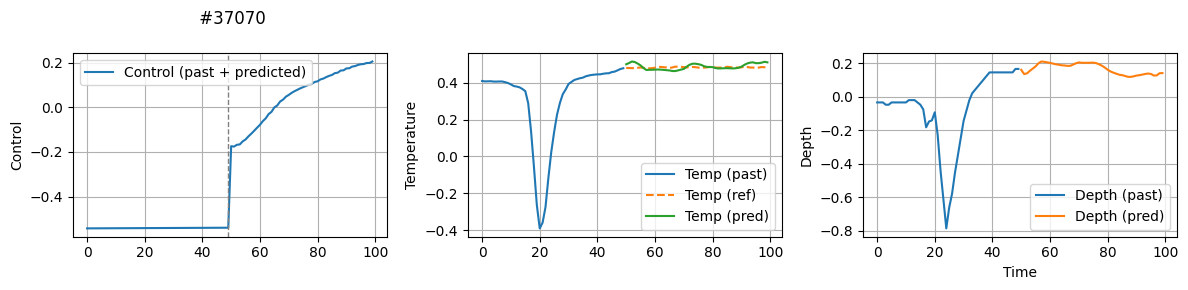

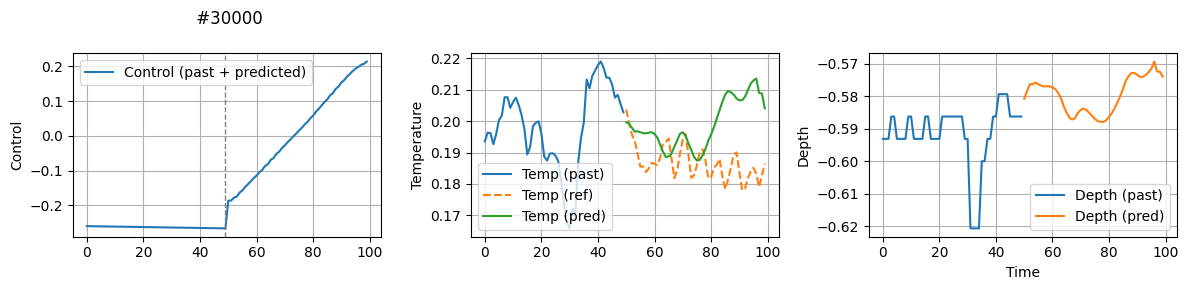

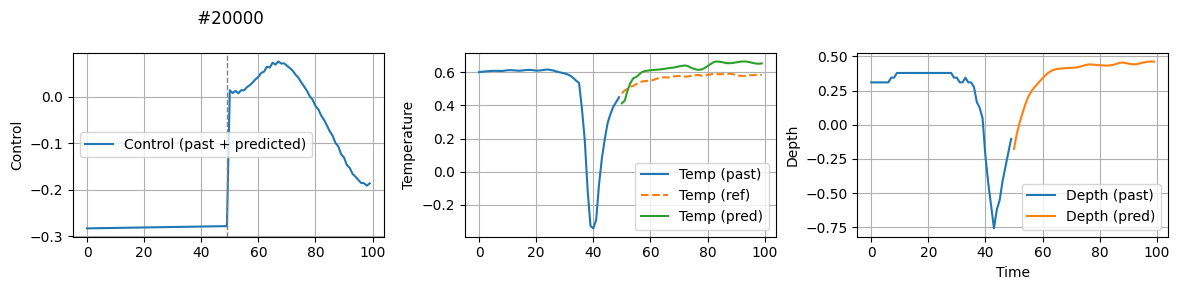

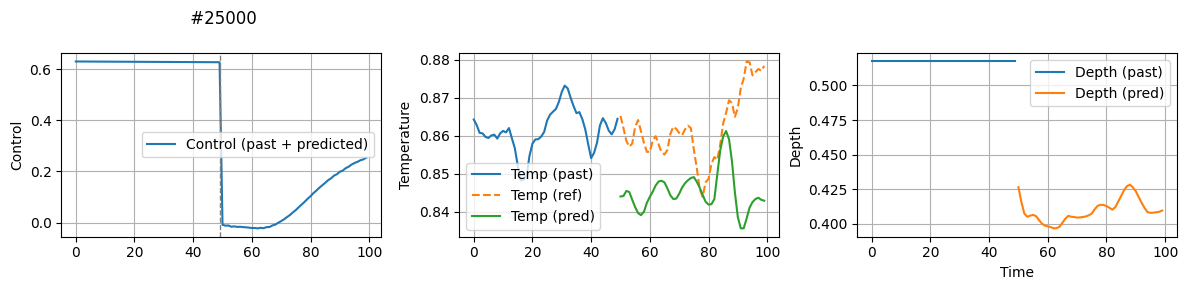

In [ ]:
import matplotlib.pyplot as plt

model = load_policy_model(3, 1024, 1, 0, device='cuda')
import matplotlib.pyplot as plt

# 1행 3열 subplot 생성
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)  # sharey=True 해도 됨
ax_list = [axs[0], axs[1], axs[2]]  # 또는 list(axs)

#35870
plot_val_sample_policy_TiDE(k=35870+1200, model=model, TiDE=TiDE, val_x_past=x_past_val, val_y_past=y_past_val, val_x_future=x_future_val, val_y_ref=y_ref_val_seq, val_y_const=y_const_val_seq, u_past_shift=0, u_shift=0, c_shift=0, device=device, ax_list=ax_list)
plt.tight_layout()
plt.show()

# 1행 3열 subplot 생성
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)  # sharey=True 해도 됨
ax_list = [axs[0], axs[1], axs[2]]  # 또는 list(axs)

plot_val_sample_policy_TiDE(k=30000, model=model, TiDE=TiDE, val_x_past=x_past_val, val_y_past=y_past_val, val_x_future=x_future_val, val_y_ref=y_ref_val_seq, val_y_const=y_const_val_seq, u_past_shift=0, u_shift=0, c_shift=0, device=device, ax_list=ax_list)
plt.tight_layout()
plt.show()

# 1행 3열 subplot 생성
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)  # sharey=True 해도 됨
ax_list = [axs[0], axs[1], axs[2]]  # 또는 list(axs)

plot_val_sample_policy_TiDE(k=20000, model=model, TiDE=TiDE, val_x_past=x_past_val, val_y_past=y_past_val, val_x_future=x_future_val, val_y_ref=y_ref_val_seq, val_y_const=y_const_val_seq, u_past_shift=0, u_shift=0, c_shift=0, device=device, ax_list=ax_list)
plt.tight_layout()
plt.show()

# 1행 3열 subplot 생성
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)  # sharey=True 해도 됨
ax_list = [axs[0], axs[1], axs[2]]  # 또는 list(axs)

plot_val_sample_policy_TiDE(k=25000, model=model, TiDE=TiDE, val_x_past=x_past_val, val_y_past=y_past_val, val_x_future=x_future_val, val_y_ref=y_ref_val_seq, val_y_const=y_const_val_seq, u_past_shift=0, u_shift=0, c_shift=0, device=device, ax_list=ax_list)
plt.tight_layout()
plt.show()


torch.Size([60942, 50, 1])
torch.Size([60942, 50, 4])
torch.Size([60942, 50, 2])
torch.Size([300, 50, 1])
torch.Size([300, 50, 4])
torch.Size([300, 50, 2])


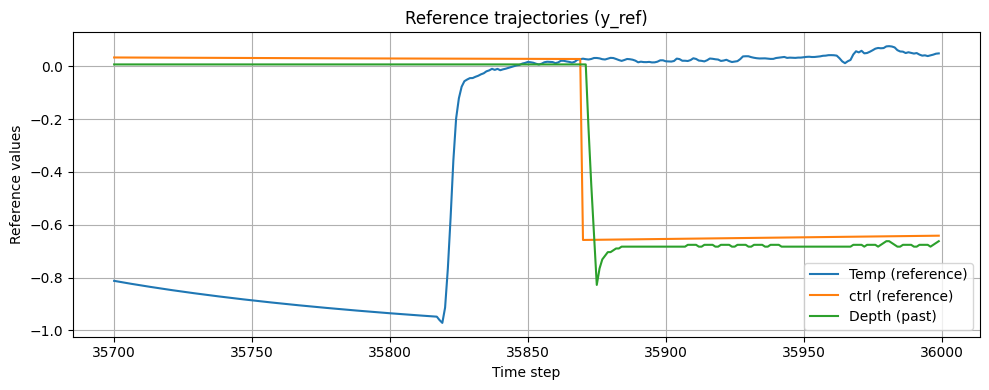

In [100]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_val_seq.shape)
print(x_past_val.shape)
print(y_past_val.shape)
start_idx = 35700
window = 36000-start_idx
y_ref_slice = y_ref_val_seq[start_idx : start_idx + window]
x_past_slice = x_past_val[start_idx : start_idx + window]
y_past_slice = y_past_val[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_ref_slice[:, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

torch.Size([549275, 50, 1])
torch.Size([549275, 50, 4])
torch.Size([549275, 50, 2])
torch.Size([90, 50, 1])
torch.Size([90, 50, 4])
torch.Size([90, 50, 2])


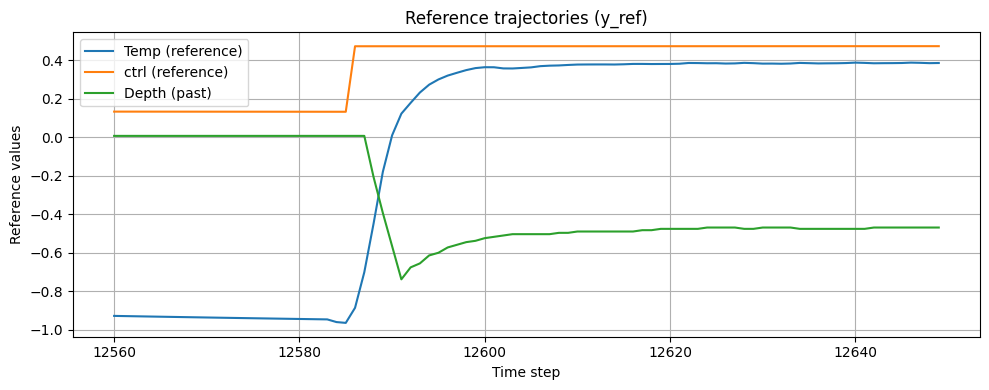

In [101]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_train_seq.shape)
print(x_past_train.shape)
print(y_past_train.shape)
start_idx = 12560
window = 12650-start_idx
y_ref_slice = y_ref_train_seq[start_idx : start_idx + window]
x_past_slice = x_past_train[start_idx : start_idx + window]
y_past_slice = y_past_train[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_past_slice[:, 0, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


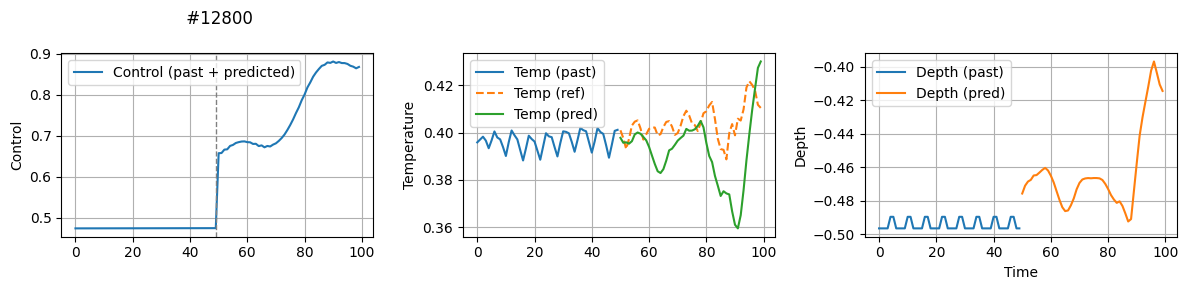

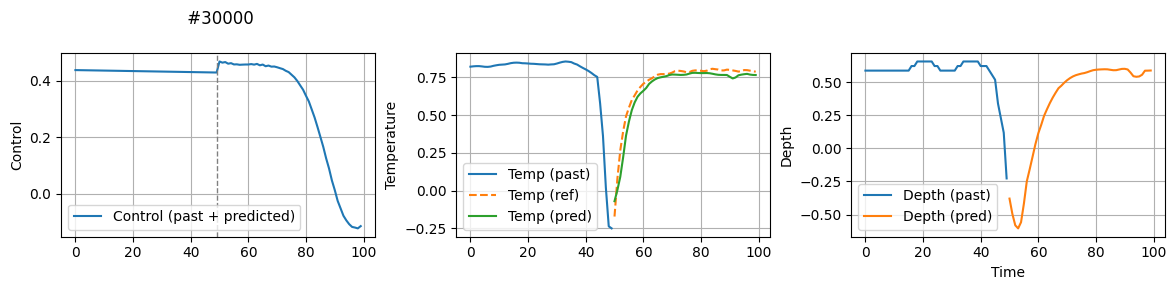

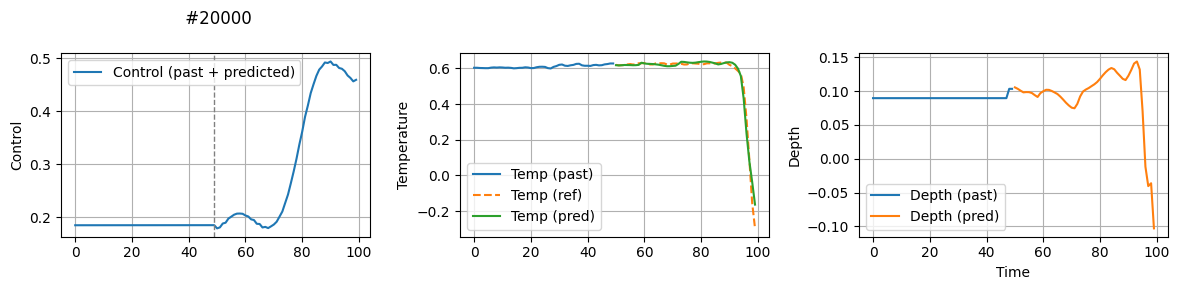

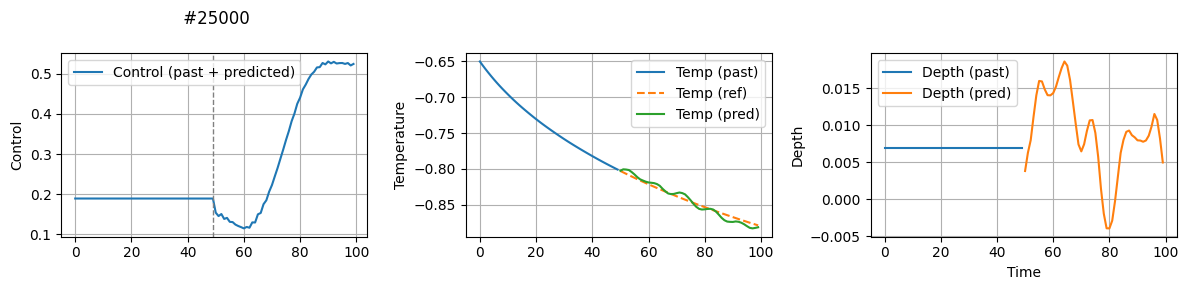

In [ ]:
import matplotlib.pyplot as plt

model = load_policy_model(3, 1024, 1, 0, device='cuda')

k_list = [12800, 30000, 20000, 25000]

for k in k_list:
    fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)
    ax_list = list(axs)
    
    plot_val_sample_policy_TiDE(
        k=k,
        model=model,
        TiDE=TiDE,
        val_x_past=x_past_train,
        val_y_past=y_past_train,
        val_x_future=x_future_train,
        val_y_ref=y_ref_train_seq,
        val_y_const=y_const_train_seq,
        u_past_shift=0,
        u_shift=0,
        c_shift=0,
        device=device,
        ax_list=ax_list
    )
    
    plt.tight_layout()
    plt.show()
